In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import TensorDataset, random_split, DataLoader
import torch.nn as nn
import time
import wandb
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
import torch
from datetime import datetime
from collections import OrderedDict
from sklearn.decomposition import PCA
import flwr as fl
from flwr.common import Metrics
from time import gmtime, strftime

now = datetime.now() # current date and time
date_time = now.strftime("%d-%m-%Y_%H:%M:%S")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device}.')

Using cuda.


In [2]:
# wandb.init(
#     # set the wandb project where this run will be logged
#     project="NASA_turbo_fan",
#     name= "with 50 data points_{}".format(date_time),
#     # track hyperparameters and run metadata
#     config={
#     "learning_rate": 0.0001,
#     "architecture": "CNN",
#     "epochs": 100,
#     "loss": nn.BCELoss(),
#     "batch_size": 64,
#     "decay":1e-5,
#     'dropout': 0.5
#     }
# )
configuration={
    "learning_rate": 0.0001,
    "architecture": "CNN",
    "epochs": 100,
    "loss": nn.BCELoss(),
    "batch_size": 64,
    "decay":1e-5,
    'dropout': 0.5
}
# configuration  = wandb.config

def data_loading_AZURE(data_path, label_path, batch_size, train_ratio=0.8, val_ratio=0.5):
    data = torch.load(data_path)
    labels = torch.load(label_path)
    data = nn.functional.normalize(data, dim=1)
    data = data[:700, :, :]
    labels = labels[:700]
    print((labels==1).sum())
    # reshaping the dataset so  the channels will be the second dimension.
    data = data.permute(0, 2, 1)
    print(data.size())
    n_samples, n_channels, n_features = data.shape
    X_reshaped = data.reshape(n_samples, -1) 
    # Apply SMOTE
    smote = SMOTE(sampling_strategy='minority')
    data_resampled, labels_resampled = smote.fit_resample(X_reshaped, labels)
    print((labels_resampled==1).sum())
    # Reshape X_resampled back to 3D
    data_resampled = data_resampled.reshape(-1, n_channels, n_features)
    print(data_resampled.shape)
    data_resampled = torch.tensor(data_resampled)
    labels_resampled = torch.tensor(labels_resampled)
    dataset = TensorDataset(data_resampled, labels_resampled)
    train_size = int(train_ratio * len(dataset))
    test_size = len(dataset) - train_size
    val_size = int(val_ratio * test_size)
    test_size = test_size - val_size

    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
    return DataLoader(train_dataset, batch_size=batch_size, shuffle=True), DataLoader(val_dataset, batch_size=batch_size, shuffle=True), DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

def data_loading_NASA(data_path, label_path, batch_size, train_ratio=0.8, val_ratio = 0.5):
    data = torch.load(data_path)
    labels = torch.load(label_path)
    data = nn.functional.normalize(data, dim=1)
    # reshaping the dataset so  the channels will be the second dimension.
    data = data.permute(0, 2, 1)
    print(data.size())
    
    def pca_reduction(data, n_components=4):
        data_reshaped = data.reshape(-1, data.shape[1])

        # Apply PCA
        pca = PCA(n_components=n_components)
        
        data_reduced = pca.fit_transform(data_reshaped)

        # Reshape back to (samples, n_components, time_steps)
        data_reduced = data_reduced.reshape(data.shape[0], n_components, data.shape[2])

        return data_reduced
    print(data.dtype)
    data = pca_reduction(data, n_components=4)
    data =(torch.from_numpy(data)).float()
    n_samples, n_channels, n_features = data.shape
    X_reshaped = data.reshape(n_samples, -1) 
    
    # Apply SMOTE
    smote = SMOTE(sampling_strategy='minority')
    data_resampled, labels_resampled = smote.fit_resample(X_reshaped, labels)
    print((labels_resampled==1).sum())
    # Reshape X_resampled back to 3D
    data_resampled = data_resampled.reshape(-1, n_channels, n_features)
    print(data_resampled.shape)
    data_resampled = torch.tensor(data_resampled)
    labels_resampled = torch.tensor(labels_resampled)
    dataset = TensorDataset(data_resampled, labels_resampled)
    train_size = int(train_ratio * len(dataset))
    test_size = len(dataset) - train_size
    val_size = int(val_ratio * test_size)
    test_size = test_size - val_size
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
    return DataLoader(train_dataset, batch_size=batch_size, shuffle=True), DataLoader(val_dataset, batch_size=batch_size, shuffle=True), DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [3]:
# Define the CNN architecture
class SimpleCNN(nn.Module):
    def __init__(self, dropout):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=4, out_channels=8, kernel_size=5)
        self.bn1 = nn.BatchNorm1d(8)
        self.conv2 = nn.Conv1d(in_channels=8, out_channels=8, kernel_size=5)
        self.bn2 = nn.BatchNorm1d(8)
        self.pool = nn.MaxPool1d(kernel_size=2, padding=0, stride=1)
        # the size of the out channels x number  of nodes 
        self.fc1 = nn.Linear(328, 200)
        self.fc2 = nn.Linear(200, 2)
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.dropout(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x - self.dropout(x)
        x = self.sigmoid(self.fc2(x))
        return x

In [4]:
def correct(logits, y):
    y_hat = logits.argmax(axis=1) # Finds the column with the highest value for each row of `logits`.
    return (y_hat == y).float().sum() # Computes the number of times that `y_hat` and `y` match.

def evaluate_metric(model, data_iter, metric):
    """Compute the average `metric` of the model on a dataset."""
    c = torch.tensor(0.).to(device)
    n = torch.tensor(0.).to(device)
    for X, y in data_iter:
        X, y = X.to(device), y.to(device) # Moves data to `device`
        logits = model(X)
        c += metric(logits, y)
        n += len(y)
    return c*100 / n


In [6]:
t = next(iter(test_loaders))
for x, yy in t:
    print(x)

NameError: name 'test_loaders' is not defined

In [7]:
def train(model, train_loaders, config, epochs):
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=config['decay'])
        
    for epoch in range(epochs):
        print(f'\nEpoch {epoch + 1}/{epochs}')
        total, epoch_loss = 0, 0.0
        model.train() # This is necessary because batch normalization behaves differently between training and evaluation
        losses = [] # Stores the loss for each training batch
        train_accs = [] # Stores the training accuracy after each epoch
        for X, y in train_loaders:
            X, y = X.to(device), y.to(device) # Moves data to `device`
            logits = model(X) # Computes the logits for the batch of images `X`
            l = loss(logits, y) # Computes the loss given the `logits` and the class vector `y`
            optimizer.zero_grad() # Zeroes the gradients stored in the model parameters
            l.backward() # Computes the gradient of the loss `l` with respect to the model parameters

            optimizer.step() # Updates the model parameters based on the gradients stored inside them
            epoch_loss += l
            # train_loss = float(l)
            # losses.append(train_loss) # Stores the loss for this batch
            model.eval() # This is necessary because batch normalization behaves differently between training and evaluation
            train_acc = evaluate_metric(model, train_loaders, correct)
            train_accs.append(train_acc)
            # wandb.log({"train_loss": losses,
            #            "train_acc": train_accs,
            #            "Epoch": epoch + 1})
            # print(f'Epoch {epoch+1}: Training accuracy: {train_accs[-1]}.') # Computes and displays training/testing dataset accuracy.

def test(model, test_loaders,  configuration):
    loss = nn.CrossEntropyLoss()
    test_accs = []
    optimizer = torch.optim.Adam(model.parameters(), lr=configuration['learning_rate'], weight_decay=configuration['decay'])
    test_acc = []
    loss_val = 0.0
    model.eval() # This is necessary because batch normalization behaves differently between training and evaluation
    for X, y in test_loaders:    
        X, y = X.to(device), y.to(device) # Moves data to `device`
        logits = model(X)
        l = loss(logits, y).item()
        test_acc = evaluate_metric(model, test_loaders, correct)
        test_accs.append(test_acc)
        
        # wandb.log({"test_acc": test_acc})
        loss_val /= len(test_loaders)
        end_time = time.perf_counter()
        # print('Testing accuracy: {test_accs[-1]}.')
        return loss_val, test_acc

NASA = data_loading_NASA(data_path='NASA_data_50.pt', label_path= 'NASA_label_50.pt', batch_size= configuration['batch_size'])
AZURE = data_loading_AZURE(data_path='AZURE_data_50.pt', label_path='AZURE_label_50.pt', batch_size= configuration['batch_size'])
train_loaders = [NASA[0], AZURE[0]]
val_loaders = [NASA[1], AZURE[1]]
test_loaders = [NASA[2], AZURE[2]]

torch.Size([848, 24, 50])
torch.float32
685
(1370, 4, 50)
tensor(64)
torch.Size([700, 4, 50])
636
(1272, 4, 50)



Epoch 1/1
Epoch 1: validation loss 0.0, accuracy 55.47445297241211

Epoch 1/1
Epoch 2: validation loss 0.0, accuracy 55.47445297241211

Epoch 1/1
Epoch 3: validation loss 0.0, accuracy 55.47445297241211

Epoch 1/1
Epoch 4: validation loss 0.0, accuracy 55.47445297241211

Epoch 1/1
Epoch 5: validation loss 0.0, accuracy 55.47445297241211

Epoch 1/1
Epoch 6: validation loss 0.0, accuracy 55.47445297241211

Epoch 1/1
Epoch 7: validation loss 0.0, accuracy 58.394161224365234

Epoch 1/1
Epoch 8: validation loss 0.0, accuracy 55.47445297241211

Epoch 1/1
Epoch 9: validation loss 0.0, accuracy 58.394161224365234

Epoch 1/1
Epoch 10: validation loss 0.0, accuracy 62.04379653930664

Epoch 1/1
Epoch 11: validation loss 0.0, accuracy 55.47445297241211

Epoch 1/1
Epoch 12: validation loss 0.0, accuracy 43.79561996459961

Epoch 1/1
Epoch 13: validation loss 0.0, accuracy 56.20438003540039

Epoch 1/1
Epoch 14: validation loss 0.0, accuracy 56.93430709838867

Epoch 1/1
Epoch 15: validation loss 0.0,

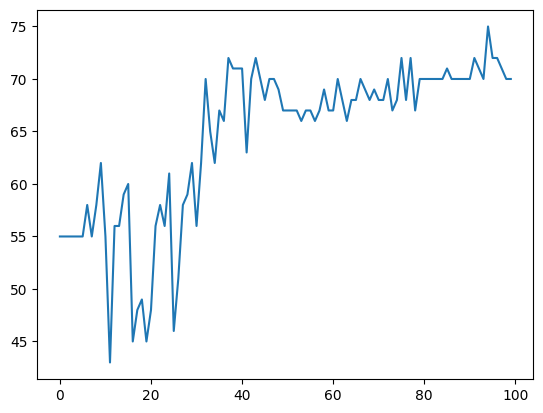

In [12]:
trainloader = train_loaders[0]
valloader = val_loaders[0]
testloader = test_loaders[0]
net = SimpleCNN(configuration['dropout']).to(device)
losses = []
accuracies = []
for epoch in range(100):
    train(net, trainloader, configuration, configuration['epochs'])
    loss, accuracy = test(net, valloader, configuration)
    losses.append(loss)
    accuracies.append(int(accuracy))
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")
plt.plot(accuracies)
loss, accuracy = test(net, testloader, configuration=configuration)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

In [13]:
def get_parameters(net):
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


def set_parameters(net, parameters):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)



class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}
    

def client_fn(cid) -> FlowerClient:
    net = SimpleCNN(dropout=configuration['dropout']).to(device)
    trainloader = train_loaders[int(cid)]
    valloader = val_loaders[int(cid)]
    return FlowerClient(cid, net, trainloader, valloader).to_client()


# # Flower ClientApp
# app = ClientApp(
#     client_fn=client_fn,)

# if __name__ == "__main__":
#     from flwr.client import start_client

#     start_client(
#         server = "0.0.0.0:8080",
#         client = FlowerClient()
#     )

In [14]:
# client will be allocated 1x CPU and 0x GPUs
client_resources = {"num_cpus": 1, "num_gpus": 0.0}
if device.type == "cuda":
    # here we are assigning an entire GPU for each client.
    client_resources = {"num_cpus": 1, "num_gpus": 1.0}
    # Refer to our documentation for more details about Flower Simulations
    # and how to setup these `client_resources`.

fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=2,
    config=fl.server.ServerConfig(num_rounds=5),
    strategy=fl.server.strategy.FedAvg(),
    client_resources=client_resources
)

INFO :      Starting Flower simulation, config: num_rounds=5, no round_timeout
2024-07-26 21:26:29,029	INFO worker.py:1621 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'object_store_memory': 38421959884.0, 'accelerator_type:G': 1.0, 'GPU': 2.0, 'CPU': 32.0, 'memory': 79651239732.0, 'node:192.168.1.146': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 1.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
INFO :      Received initial parameters from one random client
INFO :      Evaluating initial global parameters
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)
ERROR :     Traceback (most recent 

(ClientAppActor pid=1881959) [Client 1] get_parameters
(ClientAppActor pid=1881959) [Client 1] fit, config: {}


ERROR :     Traceback (most recent call last):
  File "/home/diba/miniconda3/envs/FTL/lib/python3.10/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 73, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
  File "/home/diba/miniconda3/envs/FTL/lib/python3.10/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 399, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/diba/miniconda3/envs/FTL/lib/python3.10/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 280, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
  File "/home/diba/miniconda3/envs/FTL/lib/python3.10/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/diba/miniconda3/envs/FTL/lib/python3.10/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/home/diba/miniconda3/envs/FTL/l

(ClientAppActor pid=1881957) [Client 0] evaluate, config: {}


ERROR :     Traceback (most recent call last):
  File "/home/diba/miniconda3/envs/FTL/lib/python3.10/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 73, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
  File "/home/diba/miniconda3/envs/FTL/lib/python3.10/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 399, in get_client_result
    return self._fetch_future_result(cid)
  File "/home/diba/miniconda3/envs/FTL/lib/python3.10/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 280, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
  File "/home/diba/miniconda3/envs/FTL/lib/python3.10/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/diba/miniconda3/envs/FTL/lib/python3.10/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/home/diba/miniconda3/envs/FTL/l

(ClientAppActor pid=1881959) [Client 1] fit, config: {}
(ClientAppActor pid=1881959) [Client 0] evaluate, config: {}
(ClientAppActor pid=1881957) [Client 1] evaluate, config: {}


*** SIGTERM received at time=1722026211 on cpu 19 ***
PC: @     0x7f87c9e06e2e  (unknown)  epoll_wait
    @     0x7f87c9d23520  (unknown)  (unknown)
[2024-07-26 21:36:51,236 E 1782016 1782016] logging.cc:361: *** SIGTERM received at time=1722026211 on cpu 19 ***
[2024-07-26 21:36:51,236 E 1782016 1782016] logging.cc:361: PC: @     0x7f87c9e06e2e  (unknown)  epoll_wait
[2024-07-26 21:36:51,236 E 1782016 1782016] logging.cc:361:     @     0x7f87c9d23520  (unknown)  (unknown)
